In [1]:
import os
import sys
sys.path.append(os.path.join('..', 'src'))
from genes_annotations import *
from autoencoder import *
from utils import *
import matplotlib.pyplot as plt
import seaborn as sbn
import pandas as pd
import torch

In [2]:
filename = "../data_tisch2/Glioma_GSE102130_expression.h5"

h5 = read_h5(filename)

In [3]:
selected_genes = get_all_genes(h5)

In [4]:
goterm, genes_go, all_go, all_genes = get_all_gene_annotations(h5, levels=[4], kinds=['biological_process'])

HMS:0:00:11.648974 606,840 annotations READ: ../goa_human.gaf 
../go.obo: fmt(1.2) rel(2021-05-01) 50,605 GO Terms; optional_attrs(consider replaced_by)


In [5]:
mask = build_mask(h5,genes_go,all_go,all_genes)

In [6]:
expr_mat = build_expr_mat(h5)
expr_mat = select_gene_expr_v2(h5, expr_mat, all_genes)
std_expr_mat = min_max_normalisation(std_normalisation(expr_mat))

'build_expr_mat'  598.97 ms
'select_gene_expr_v2'  385.12 ms


In [29]:
np.savetxt('expr_mat.csv', expr_mat)
np.savetxt('std_expr_mat.csv', std_expr_mat)

In [8]:
ae, train_loader, embeddings = ae_pipeline(mask, std_expr_mat, all_genes, all_go, n_epochs=50, batch_size=50, print_loss=100, output_file='model_ae_modified.pth', embed_file='embeddings_ae_modified.csv')

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
              Tanh-1              [-1, 1, 2001]               0
      MaskedLinear-2              [-1, 1, 2001]               0
            Linear-3               [-1, 1, 100]         200,200
              Tanh-4               [-1, 1, 100]               0
            Linear-5              [-1, 1, 2001]         202,101
              Tanh-6              [-1, 1, 2001]               0
              Tanh-7              [-1, 1, 8925]               0
      MaskedLinear-8              [-1, 1, 8925]               0
Total params: 402,301
Trainable params: 402,301
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.03
Forward/backward pass size (MB): 0.20
Params size (MB): 1.53
Estimated Total Size (MB): 1.77
----------------------------------------------------------------
[1,    82] loss: 0.94651
[2,    82] loss: 

In [8]:
ae = torch.load('model_ae_modified.pth')
var = ae.encoder[0].var_W

In [9]:
var /= var.max()

In [28]:
df=pd.DataFrame({'score': var[all_genes.index('SNCA'),:].numpy(), 'indices': range(2001)})
df=df.iloc[:2001-100]

In [33]:
df=df.sort_values(by='score', ascending=False)

In [34]:
df.iloc[:10]

,score,indices
731,3.273784e-03,731
497,2.635335e-03,497
269,7.179459e-04,269
697,6.244496e-04,697
634,2.705365e-04,634
722,1.055428e-04,722
802,3.925853e-06,802
1657,3.263611e-06,1657
1637,2.589760e-11,1637
1612,2.446404e-11,1612


In [37]:
for i in df.indices[:10]:
    print(goterm.get_go_name(all_go[i]), df['score'][i])

response to lipopolysaccharide 0.0032737842
synaptic vesicle exocytosis 0.002635335
apoptotic process 0.0007179459
protein destabilization 0.00062444963
regulation of transmembrane transporter activity 0.00027053646
negative regulation of transporter activity 0.00010554282
cellular response to oxidative stress 3.925853e-06
supramolecular fiber organization 3.2636115e-06
dentin mineralization 2.5897597e-11
receptor-mediated endocytosis involved in cholesterol transport 2.4464037e-11


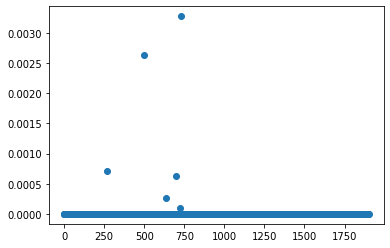

In [31]:
plt.scatter(df['indices'], df['score'])

In [11]:
ae = torch.load('model_ae_modified.pth')

In [13]:
out = ae(torch.Tensor(std_expr_mat))

In [14]:
inp = torch.Tensor(std_expr_mat)

In [15]:
nn.MSELoss()(out, inp)

tensor(0.0656, grad_fn=<MseLossBackward>)

In [16]:
out

tensor([[-0.9315, -0.9492, -0.8581,  ..., -0.8671, -0.8196, -0.7920],
        [-0.9315, -0.9492, -0.8581,  ..., -0.8671, -0.8196, -0.7920],
        [-0.9315, -0.9492, -0.8581,  ..., -0.8671, -0.8196, -0.7920],
        ...,
        [-0.9315, -0.9492, -0.8581,  ..., -0.8671, -0.8196, -0.7920],
        [-0.9315, -0.9492, -0.8581,  ..., -0.8671, -0.8196, -0.7920],
        [-0.9315, -0.9492, -0.8581,  ..., -0.8671, -0.8196, -0.7920]],
       grad_fn=<TanhBackward>)

In [17]:
inp

tensor([[-1.0000, -1.0000, -0.3176,  ..., -1.0000, -1.0000, -0.9612],
        [-1.0000, -1.0000, -0.3043,  ..., -0.3177, -0.4372, -0.8142],
        [-1.0000, -1.0000, -1.0000,  ..., -1.0000, -1.0000,  0.1647],
        ...,
        [-1.0000, -1.0000, -1.0000,  ..., -0.7477, -1.0000, -1.0000],
        [-1.0000, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -1.0000],
        [-1.0000, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -1.0000]])

In [18]:
error = torch.nn.MSELoss(reduction='none')(out, inp)

In [19]:
errors = error.sum(dim=1).detach().numpy()

(array([  5.,   3.,   6.,  13.,  51.,  96., 160., 211., 241., 251., 253.,
        218., 192., 200., 178., 161., 149., 136., 139., 137., 125., 113.,
        109., 126., 105.,  85.,  84., 102.,  81.,  55.,  72.,  43.,  34.,
         27.,  21.,  16.,  13.,  11.,  12.,   8.,   5.,   3.,   2.,   3.,
          1.,   1.,   0.,   0.,   0.,   1.]),
 array([ 213.29362,  235.96236,  258.63107,  281.2998 ,  303.96854,
         326.63727,  349.306  ,  371.9747 ,  394.64343,  417.31216,
         439.9809 ,  462.64963,  485.31836,  507.9871 ,  530.6558 ,
         553.3245 ,  575.9933 ,  598.662  ,  621.3307 ,  643.99945,
         666.66815,  689.3369 ,  712.0056 ,  734.6744 ,  757.3431 ,
         780.0118 ,  802.68054,  825.34924,  848.018  ,  870.6867 ,
         893.35547,  916.0242 ,  938.6929 ,  961.36163,  984.03033,
        1006.6991 , 1029.3678 , 1052.0365 , 1074.7052 , 1097.374  ,
        1120.0427 , 1142.7114 , 1165.3801 , 1188.049  , 1210.7177 ,
        1233.3864 , 1256.055  , 1278.7238 , 13

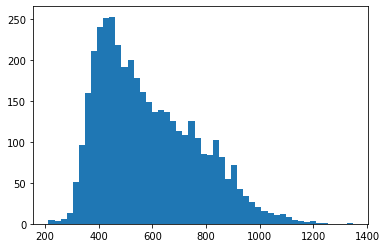

In [20]:
plt.hist(errors, bins=50)

In [21]:
errors

array([801.21356, 715.64813, 659.97864, ..., 584.11633, 782.945  ,
       893.8699 ], dtype=float32)

In [22]:
df = pd.DataFrame(errors, columns=['score'])
df.score = df.score/(df.score.max())

In [23]:
table = pd.read_csv('../data_tisch2/Glioma_GSE102130_CellMetainfo_table.tsv', delimiter='\t')
df['target'] = table['Cluster']

In [24]:
df_res = df[df.score < 0.4]

In [25]:
df_res

,score,target
22,0.393666,0
28,0.353827,14
36,0.362405,14
43,0.322736,14
44,0.379329,14
...,...,...
4049,0.312273,10
4050,0.294497,10
4051,0.287851,11
4052,0.299509,10


0.38506657
0.41660035
0.31918818
0.41541272
0.57035935
0.37467867
0.38023898
0.5372883
0.62251234
0.3207253
0.34097314
0.3000537
0.32983872
0.6113238
0.45311463


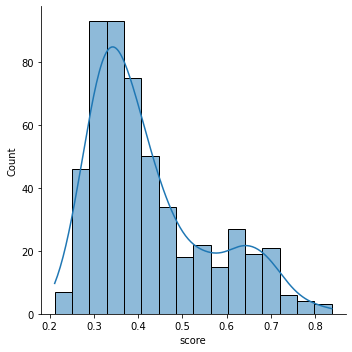

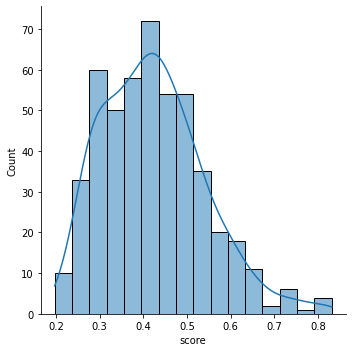

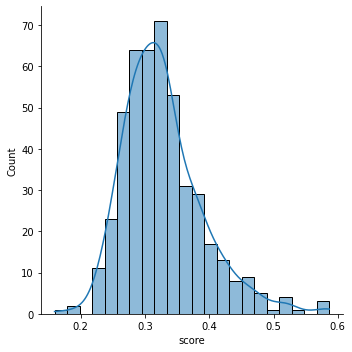

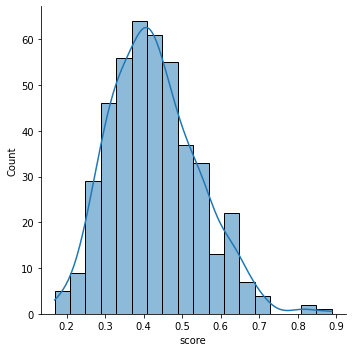

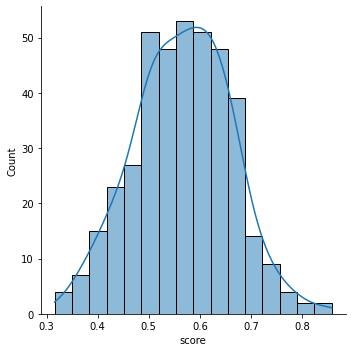

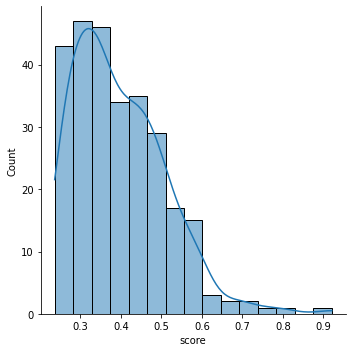

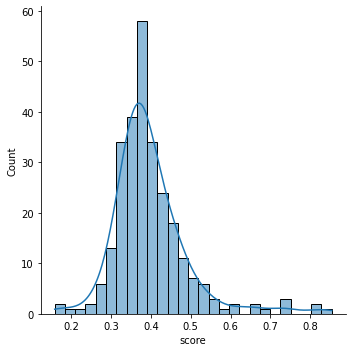

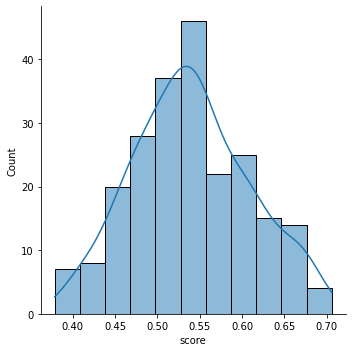

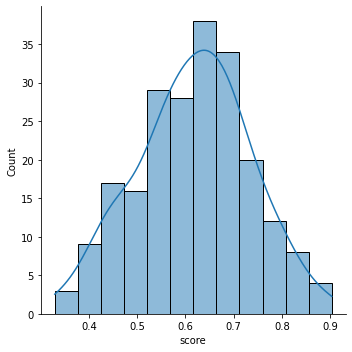

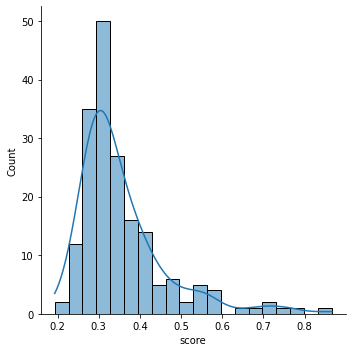

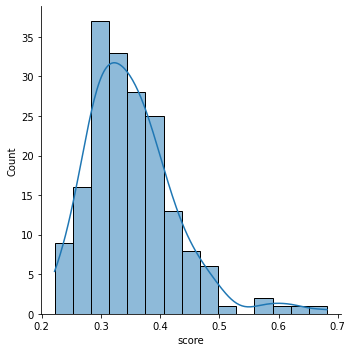

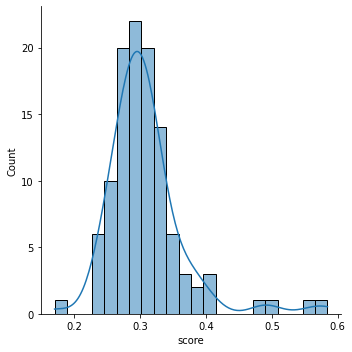

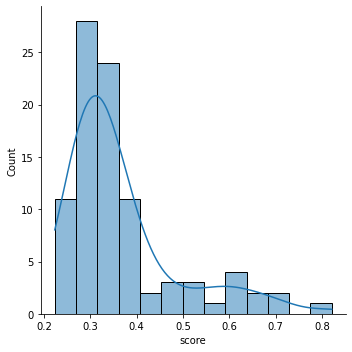

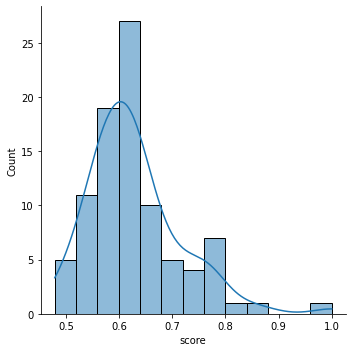

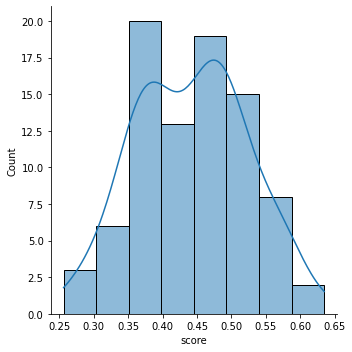

In [26]:
for k, v in df.groupby('target'):
    sbn.displot(data=v, x='score', kde=True)
    print(v.score.median())

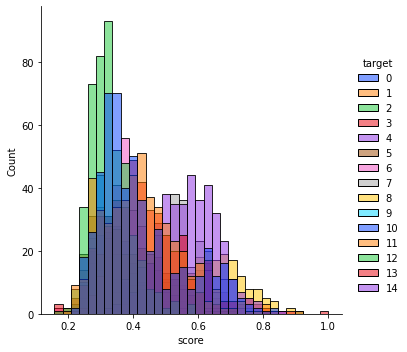

In [27]:
palette = sbn.color_palette("bright", n_colors=15)
sbn.displot(data=df, x='score', hue='target', palette=palette)

In [28]:
df.target.unique()

array([ 0, 12,  8, 14,  6, 13,  5,  9,  1,  7,  4, 10,  3,  2, 11])

In [29]:
sbn.__version__

'0.11.1'

In [30]:
data=pd.read_csv('embeddings_ae.csv', header=None)

In [31]:
data2=data[data.index.isin(df_res.index)]

In [32]:
df_res.index

Int64Index([  22,   28,   36,   43,   44,   47,   48,   53,   58,   59,
            ...
            4044, 4045, 4046, 4047, 4048, 4049, 4050, 4051, 4052, 4053],
           dtype='int64', length=1956)

../src/utils.py:33: RuntimeWarning: invalid value encountered in true_divide
  centers = centers / incr


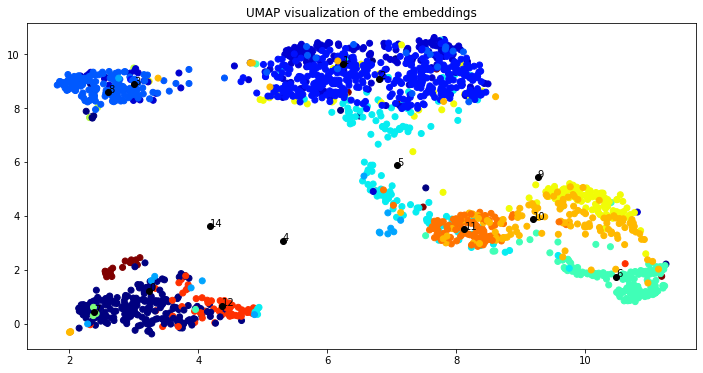

In [53]:
visualize_UMAP(data2, df_res['target'])

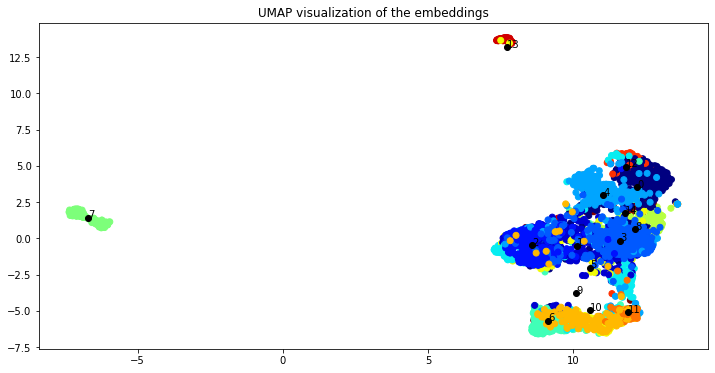

In [48]:
visualize_UMAP(data, df['target'])

In [8]:
fully = torch.ones(len(all_genes), len(all_go))
baseline, train_loader, embeddings_b = ae_pipeline(fully, std_expr_mat, all_genes, all_go, n_epochs=50, batch_size=50, print_loss=100, output_file='baseline.pth', embed_file='baseline.csv')

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
              Tanh-1              [-1, 1, 1414]               0
      MaskedLinear-2              [-1, 1, 1414]               0
            Linear-3               [-1, 1, 500]         707,500
              Tanh-4               [-1, 1, 500]               0
            Linear-5              [-1, 1, 1414]         708,414
              Tanh-6              [-1, 1, 1414]               0
              Tanh-7             [-1, 1, 10232]               0
      MaskedLinear-8             [-1, 1, 10232]               0
Total params: 1,415,914
Trainable params: 1,415,914
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.04
Forward/backward pass size (MB): 0.21
Params size (MB): 5.40
Estimated Total Size (MB): 5.65
----------------------------------------------------------------
[1,    82] loss: 0.98252
[2,    82] lo

In [9]:
table = pd.read_csv('../data_tisch2/Glioma_GSE102130_CellMetainfo_table.tsv', delimiter='\t')
targets = np.array(table['Cluster'])
clf, train_loader, embeddings = clf_pipeline(mask, std_expr_mat, targets, all_genes, all_go, n_epochs=100, batch_size=50, print_loss=100, output_file='model_clf.pth', embed_file='embeddings_clf.csv')

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
              Tanh-1              [-1, 1, 2015]               0
      MaskedLinear-2              [-1, 1, 2015]               0
            Linear-3               [-1, 1, 100]         201,600
              Tanh-4               [-1, 1, 100]               0
            Linear-5                [-1, 1, 15]           1,515
           Softmax-6                [-1, 1, 15]               0
Total params: 203,115
Trainable params: 203,115
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.03
Forward/backward pass size (MB): 0.03
Params size (MB): 0.77
Estimated Total Size (MB): 0.84
----------------------------------------------------------------
[1,    82] loss: 2.70520, accuracy: 0.09266
[2,    82] loss: 2.61862, accuracy: 0.43963
[3,    82] loss: 2.48144, accuracy: 0.65796
[4,    82] loss: 2.36025, accuracy: 0.

In [3]:
clf = torch.load("model_clf.pth")

In [10]:
np.savetxt('scores_clf.csv', clf.get_current_score().numpy(), delimiter=' ')

In [16]:
W1 = next(clf.encoder[0].parameters())

In [9]:
W2 = torch.transpose(next(clf.encoder[1].parameters()), 0, 1)

In [10]:
W3 = torch.transpose(next(clf.clf[0].parameters()), 0, 1)

In [17]:
W1.shape, W2.shape, W3.shape

(torch.Size([10232, 1414]), torch.Size([1414, 500]), torch.Size([500, 15]))

In [18]:
M=torch.chain_matmul(W1, W2, W3).detach().numpy()

In [19]:
df = pd.DataFrame(M)

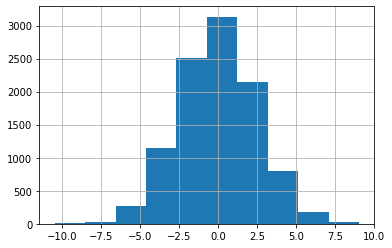

In [20]:
df[14].hist()

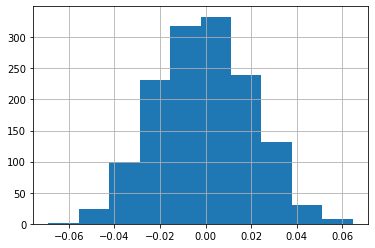

In [22]:
pd.DataFrame(W2.detach().numpy())[60].hist()

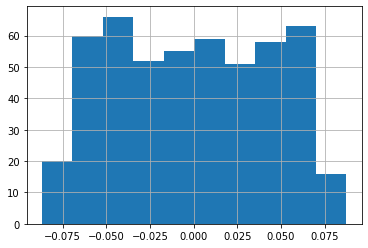

In [26]:
pd.DataFrame(W3.detach().numpy())[14].hist()

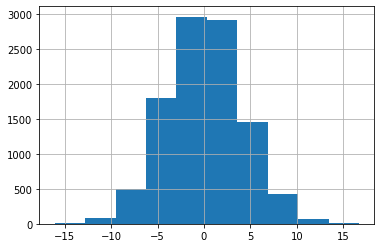

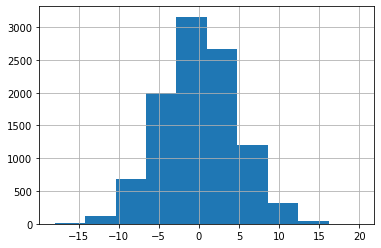

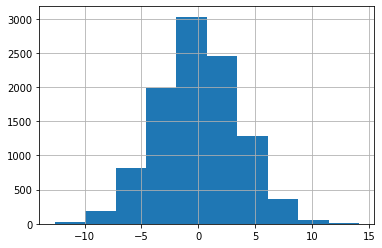

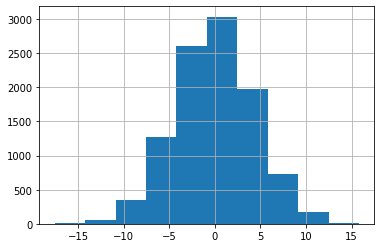

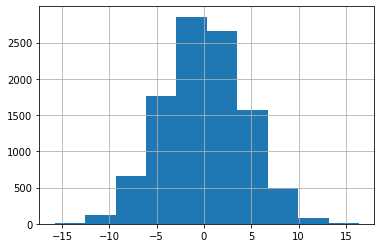

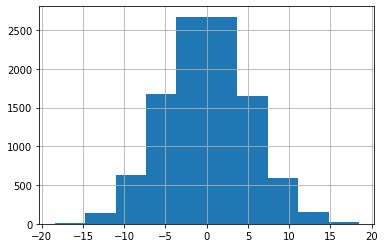

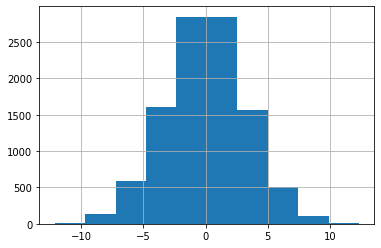

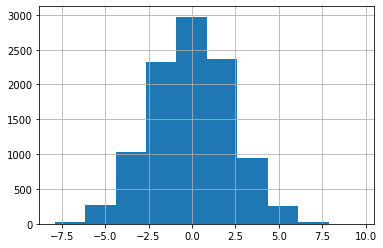

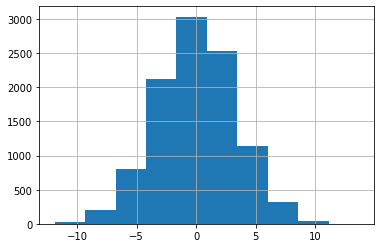

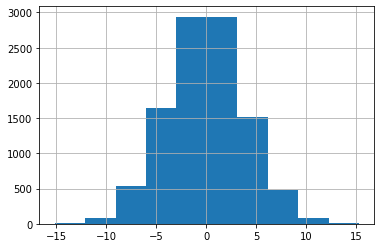

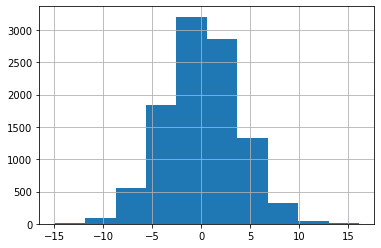

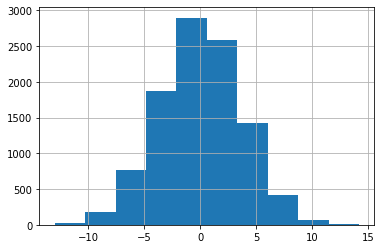

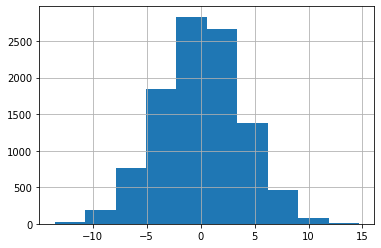

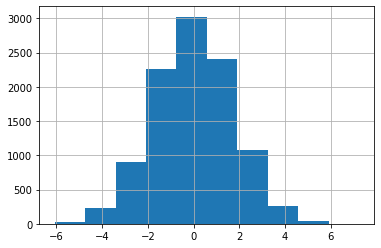

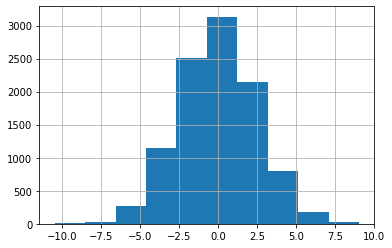

In [21]:
for i in range(15):
    plt.figure()
    df[i].hist()

In [32]:
W2.mean()

tensor(-2.3871e-05, grad_fn=<MeanBackward0>)

In [35]:
df[0].nlargest(10)

174     0.464510
709     0.375176
1145    0.341547
741     0.330161
181     0.315411
1389    0.314974
1008    0.299904
82      0.279598
558     0.277106
1035    0.271330
Name: 0, dtype: float32

In [40]:
goterm = GOTerm()

HMS:0:00:09.873736 606,840 annotations READ: ../goa_human.gaf 
../go.obo: fmt(1.2) rel(2021-02-01) 50,515 GO Terms; optional_attrs(consider replaced_by)


In [41]:
ix = df[0].nlargest(10).index

In [45]:
t = [all_go[i] for i in ix]

In [46]:
t

['GO:0004597',
 'GO:0034012',
 'GO:0061197',
 'GO:0035112',
 'GO:0004721',
 'GO:1905748',
 'GO:0050881',
 'GO:0002089',
 'GO:0021696',
 'GO:0051307']

In [48]:
for p in t:
    print(goterm.get_go_name(p))

peptide-aspartate beta-dioxygenase activity
FAD-AMP lyase (cyclizing) activity
fungiform papilla morphogenesis
genitalia morphogenesis
phosphoprotein phosphatase activity
hard palate morphogenesis
musculoskeletal movement
lens morphogenesis in camera-type eye
cerebellar cortex morphogenesis
meiotic chromosome separation


In [2]:
baseline=torch.load('baseline.pth')

In [7]:
baseline

GeneAutoEncoder(
  (encoder): Sequential(
    (0): MaskedLinear(
      (activation): Tanh()
    )
    (1): Linear(in_features=1414, out_features=500, bias=True)
    (2): Tanh()
  )
  (decoder): Sequential(
    (0): Linear(in_features=500, out_features=1414, bias=True)
    (1): Tanh()
    (2): MaskedLinear(
      (activation): Tanh()
    )
  )
)

In [3]:
W1_baseline=next(baseline.encoder[1].parameters()).detach().numpy()

In [4]:
df=pd.DataFrame(W1_baseline)

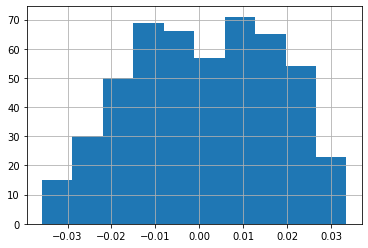

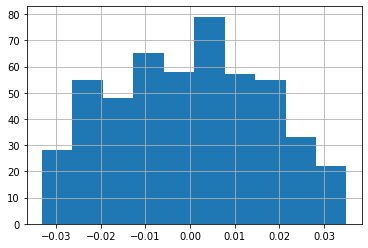

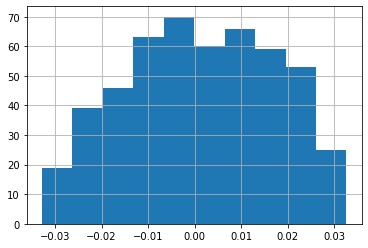

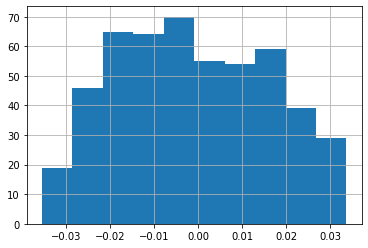

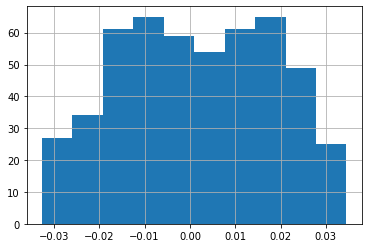

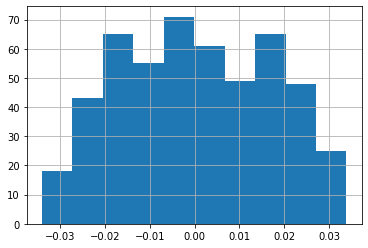

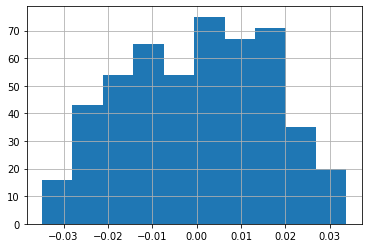

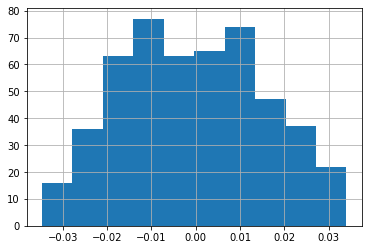

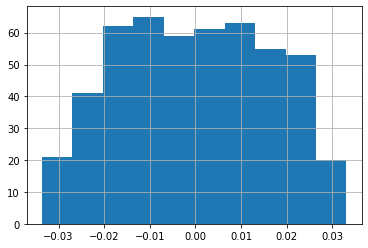

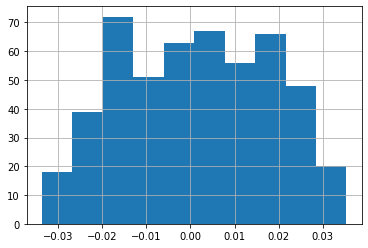

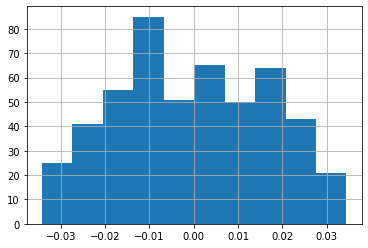

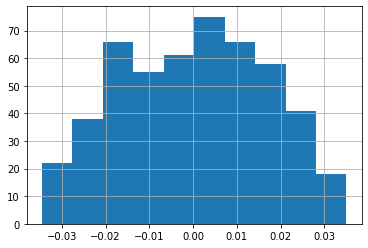

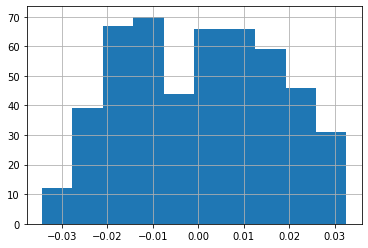

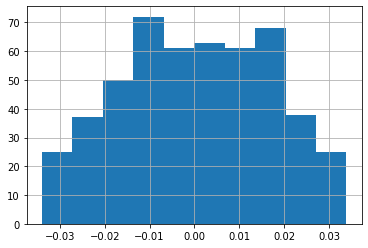

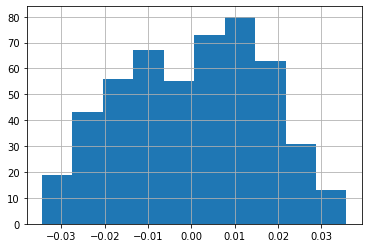

In [6]:
for i in range(15):
    plt.figure()
    df[i].hist()